In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit, cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.naive_bayes import GaussianNB
import tensorflow as tf
from tensorflow import keras
import pickle

In [6]:
# Load data
results = pd.read_csv('results.csv')
stats = pd.read_csv('stats.csv')
stats.set_index(['team'], inplace=True)

In [7]:
# Group by team for missing data imputation
grouped = stats.groupby(level='team')

# Fill missing data with average values of the same team across all seasons
numeric_cols = stats.select_dtypes(include='number').columns
team_avg = grouped[numeric_cols].mean().round(2)
team_avg = team_avg.fillna(method='ffill')

for team, group in grouped:
    if len(group) > 1:
        avg_values = team_avg.loc[team]
        for col in numeric_cols:
            stats.at[team, col] = stats.at[team, col].fillna(avg_values[col])
    else:
        continue

stats = stats.fillna(0)

In [8]:
# Prepare features and labels
df_goals = stats[['goals', 'ontarget_scoring_att', 'hit_woodwork', 'goals_conceded', 'total_pass', 'clean_sheet', 'season']]
merged_df = pd.merge(results, df_goals, left_on=['home_team', 'season'], right_on=['team', 'season'], how='left')
merged_df = pd.merge(merged_df, df_goals, left_on=['away_team', 'season'], right_on=['team', 'season'], how='left', suffixes=('_home', '_away'))

merged_df = pd.get_dummies(merged_df, columns=['season'], dtype=int)

teams = merged_df['home_team'].unique().tolist()
team_label_map = {team: label for label, team in enumerate(teams)}
merged_df['home_team_label'] = merged_df['home_team'].map(team_label_map)
merged_df['away_team_label'] = merged_df['away_team'].map(team_label_map)

columns_to_drop = ['home_team', 'away_team', 'result']
merged_df = merged_df.drop(columns=columns_to_drop)

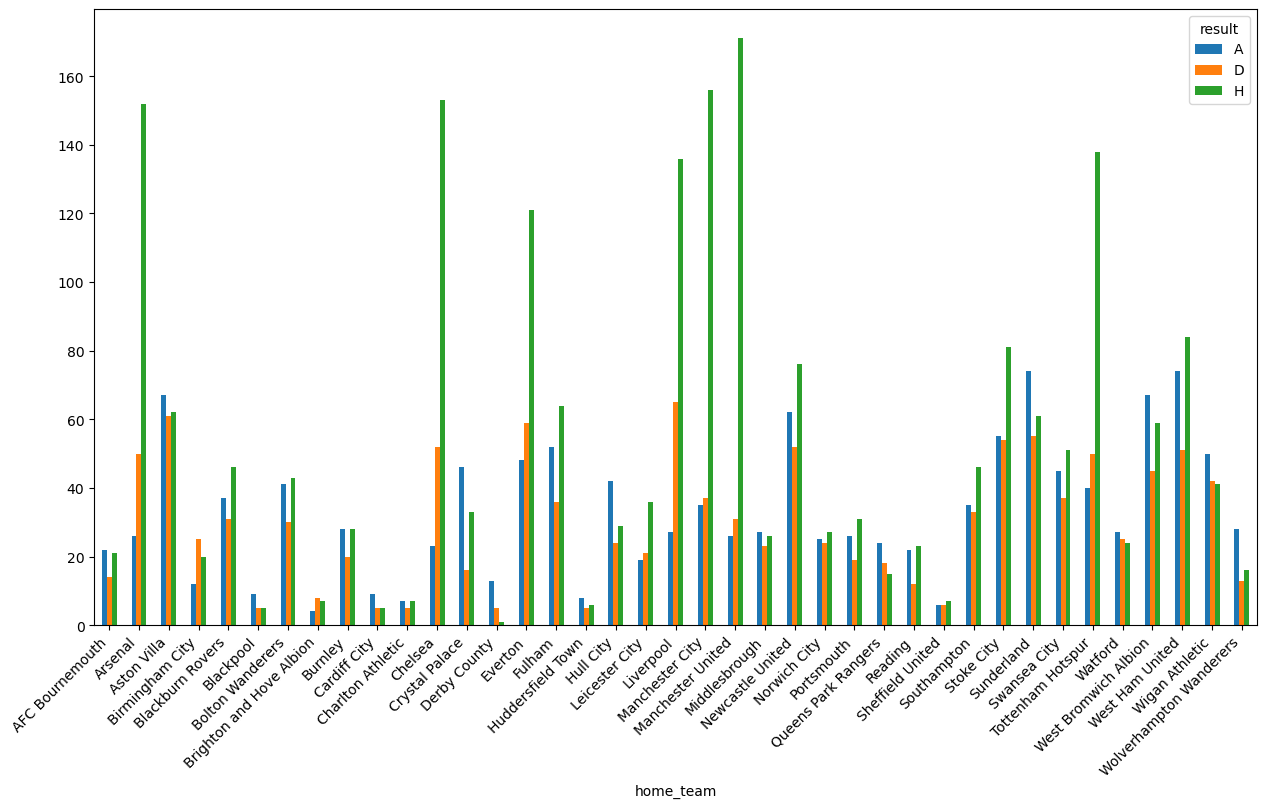

In [34]:
# Plot the crosstab with specified figsize
pd.crosstab(results.home_team, results.result).plot(kind='bar', figsize=(15, 8))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

Text(0.5, 1.0, 'Correlation Matrix of Variables (Excluding Season and Y Variables)')

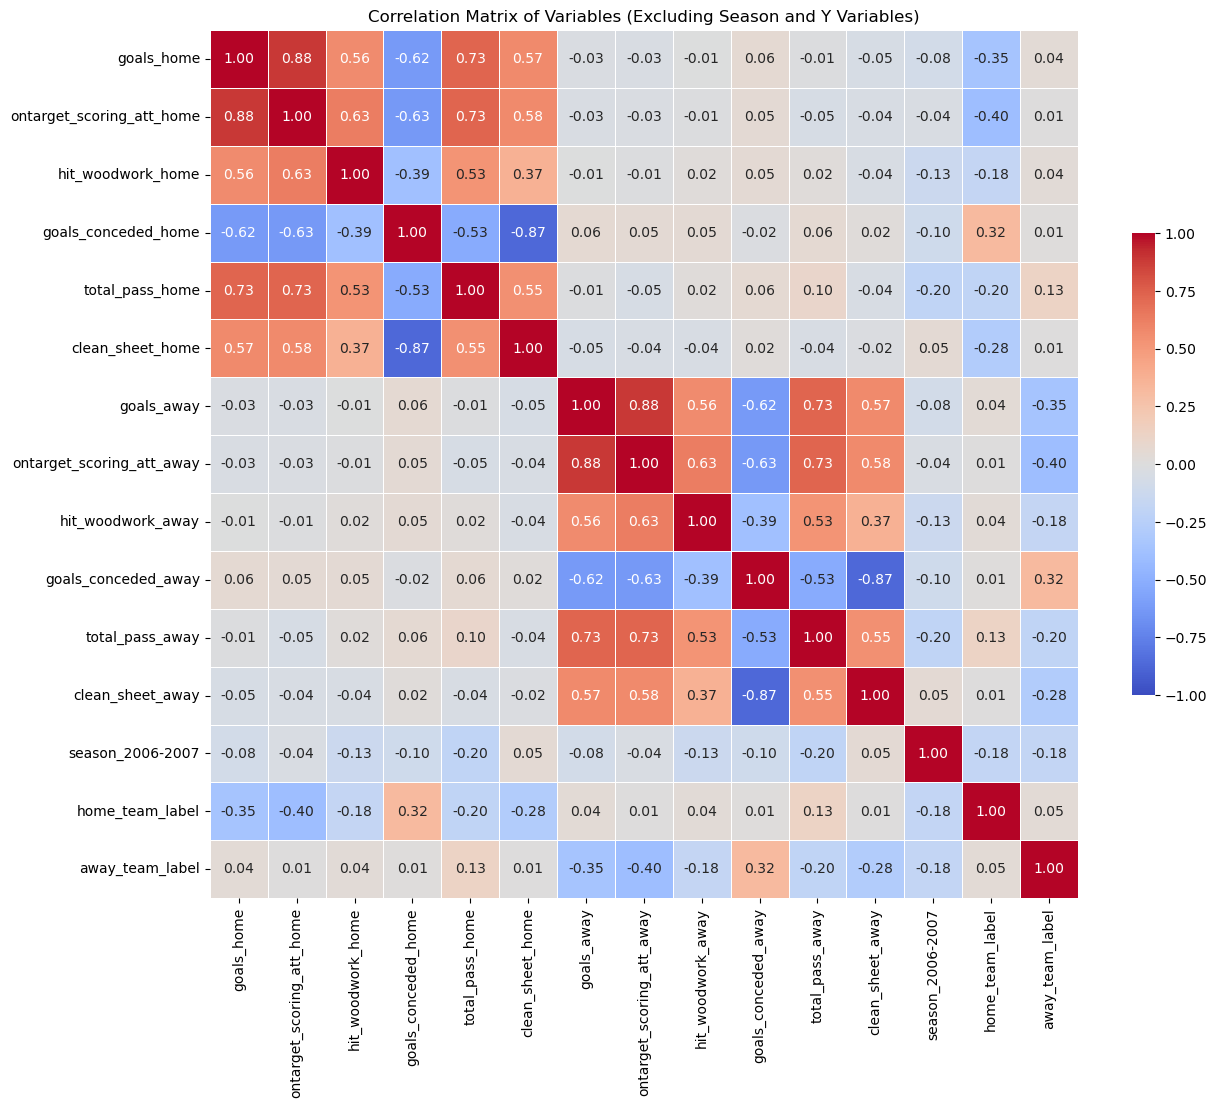

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Selecting columns to exclude
exclude_cols = ['season_2007-2008', 'season_2008-2009', 'season_2009-2010', 'season_2010-2011', 
                'season_2011-2012', 'season_2012-2013', 'season_2013-2014', 'season_2014-2015', 
                'season_2015-2016', 'season_2016-2017', 'season_2017-2018', 'home_goals', 'away_goals']

# Create a copy of the DataFrame excluding the specified columns
merged_df_filtered = merged_df.drop(columns=exclude_cols)

# Compute the correlation matrix
corr_matrix = merged_df_filtered.corr()

# Set up the matplotlib figure
plt.figure(figsize=(14, 12))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot_kws={"size": 10})

plt.title('Correlation Matrix of Variables (Excluding Season and Y Variables)')

In [36]:
correlation = merged_df['clean_sheet_home'].corr(merged_df['home_goals'])  # Replace 'home_goals' with the appropriate target variable
print("Correlation between total_tackle_away and home_goals:", correlation)

Correlation between total_tackle_away and home_goals: 0.2135056164723036


In [9]:
# Feature scaling
scaler = MinMaxScaler()
columns_to_scale = ['goals_home', 'ontarget_scoring_att_home', 'hit_woodwork_home', 'goals_conceded_home', 
                    'total_pass_home', 'clean_sheet_home', 'goals_away', 'ontarget_scoring_att_away',
                    'hit_woodwork_away', 'goals_conceded_away', 'total_pass_away', 'clean_sheet_away']
merged_df[columns_to_scale] = scaler.fit_transform(merged_df[columns_to_scale])

In [10]:
# Prepare features and labels
y_home_goals = merged_df['home_goals']
y_away_goals = merged_df['away_goals']
X = merged_df.drop(columns=['home_goals', 'away_goals'], axis=1)

In [12]:
merged_df.shape

(4560, 28)

In [11]:
# Correlation analysis
exclude_cols = ['season_2007-2008', 'season_2008-2009', 'season_2009-2010', 'season_2010-2011', 
                'season_2011-2012', 'season_2012-2013', 'season_2013-2014', 'season_2014-2015', 
                'season_2015-2016', 'season_2016-2017', 'season_2017-2018', 'home_goals', 'away_goals']
merged_df_filtered = merged_df.drop(columns=exclude_cols)
corr_matrix = merged_df_filtered.corr()

In [65]:
team_label_map

{'Sheffield United': 0,
 'Arsenal': 1,
 'Everton': 2,
 'Newcastle United': 3,
 'Portsmouth': 4,
 'Reading': 5,
 'West Ham United': 6,
 'Bolton Wanderers': 7,
 'Manchester United': 8,
 'Chelsea': 9,
 'Watford': 10,
 'Tottenham Hotspur': 11,
 'Aston Villa': 12,
 'Manchester City': 13,
 'Blackburn Rovers': 14,
 'Charlton Athletic': 15,
 'Fulham': 16,
 'Middlesbrough': 17,
 'Liverpool': 18,
 'Wigan Athletic': 19,
 'Sunderland': 20,
 'Derby County': 21,
 'Birmingham City': 22,
 'Hull City': 23,
 'Stoke City': 24,
 'West Bromwich Albion': 25,
 'Wolverhampton Wanderers': 26,
 'Burnley': 27,
 'Blackpool': 28,
 'Queens Park Rangers': 29,
 'Swansea City': 30,
 'Norwich City': 31,
 'Southampton': 32,
 'Crystal Palace': 33,
 'Cardiff City': 34,
 'Leicester City': 35,
 'AFC Bournemouth': 36,
 'Brighton and Hove Albion': 37,
 'Huddersfield Town': 38}

In [18]:
from sklearn.preprocessing import MinMaxScaler

# Identify the columns you want to scale
columns_to_scale = ['goals_home', 'ontarget_scoring_att_home', 'hit_woodwork_home', 'goals_conceded_home', 
                    'total_pass_home', 'clean_sheet_home', 'goals_away', 'ontarget_scoring_att_away',
                    'hit_woodwork_away', 'goals_conceded_away', 'total_pass_away', 'clean_sheet_away']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to the selected columns and transform them
X[columns_to_scale] = scaler.fit_transform(X[columns_to_scale])
X

,goals_home,ontarget_scoring_att_home,hit_woodwork_home,goals_conceded_home,total_pass_home,clean_sheet_home,goals_away,ontarget_scoring_att_away,hit_woodwork_away,goals_conceded_away,total_pass_away,clean_sheet_away,season_2006-2007,season_2007-2008,season_2008-2009,season_2009-2010,season_2010-2011,season_2011-2012,season_2012-2013,season_2013-2014,season_2014-2015,season_2015-2016,season_2016-2017,season_2017-2018,home_team_label,away_team_label
0,0.139535,0.273196,0.344828,0.492537,0.087673,0.318182,0.430233,0.618557,0.379310,0.074627,0.409103,0.818182,1,0,0,0,0,0,0,0,0,0,0,0,0,18
1,0.500000,0.680412,0.517241,0.194030,0.478602,0.454545,0.267442,0.309278,0.172414,0.283582,0.201247,0.500000,1,0,0,0,0,0,0,0,0,0,0,0,1,12
2,0.372093,0.304124,0.172414,0.208955,0.149017,0.545455,0.104651,0.211340,0.206897,0.552239,0.037148,0.318182,1,0,0,0,0,0,0,0,0,0,0,0,2,10
3,0.209302,0.237113,0.241379,0.373134,0.274476,0.227273,0.197674,0.273196,0.172414,0.552239,0.099931,0.363636,1,0,0,0,0,0,0,0,0,0,0,0,3,19
4,0.290698,0.474227,0.172414,0.298507,0.167244,0.454545,0.372093,0.314433,0.034483,0.477612,0.242765,0.272727,1,0,0,0,0,0,0,0,0,0,0,0,4,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4555,0.220930,0.283505,0.275862,0.373134,0.242499,0.318182,0.488372,0.649485,0.241379,0.238806,0.628151,0.636364,0,0,0,0,0,0,0,0,0,0,0,1,3,9
4556,0.197674,0.262887,0.379310,0.507463,0.410169,0.272727,1.000000,0.881443,0.655172,0.074627,1.000000,0.727273,0,0,0,0,0,0,0,0,0,0,0,1,32,13
4557,0.093023,0.046392,0.137931,0.507463,0.332729,0.318182,0.174419,0.195876,0.137931,0.686567,0.181954,0.181818,0,0,0,0,0,0,0,0,0,0,0,1,30,24
4558,0.627907,0.628866,0.310345,0.208955,0.649257,0.636364,0.418605,0.283505,0.137931,0.567164,0.304962,0.318182,0,0,0,0,0,0,0,0,0,0,0,1,11,35


In [19]:
# Model selection and evaluation
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=10)
home_scores = cross_val_score(LinearRegression(), X, y_home_goals, cv=cv, scoring='neg_mean_squared_error')
home_mse_scores = -home_scores
home_mean_mse = home_mse_scores.mean()
print('home_mean_mse', home_mean_mse)

away_scores = cross_val_score(LinearRegression(), X, y_away_goals, cv=cv, scoring='neg_mean_squared_error')
away_mse_scores = -away_scores
away_mean_mse = away_mse_scores.mean()
print('away_mean_mse', away_mean_mse)

home_mean_mse 1.4147718381874832
away_mean_mse 1.088185556994973


In [23]:
# Hyperparameter tuning
def find_best_model_using_gridsearchcv(X, y):
    algos = {
        'lr': {'model': LinearRegression()},
        'decision_tree': {'model': DecisionTreeRegressor(), 'params': {'criterion': ['mse', 'friedman_mse'], 'splitter': ['best', 'random']}},
        'random_forest': {'model': RandomForestRegressor(), 'params': {'n_estimators': [10, 50, 100], 'max_depth': [None, 5, 10], 'min_samples_split': [2, 5, 10]}},
        'svm': {'model': SVR(), 'params': {'kernel': ['linear', 'rbf'], 'C': [1, 10, 100], 'gamma': ['scale', 'auto']}},
        'naive_bayes': {'model': GaussianNB(), 'params': {}}
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        model = config['model']
        params = config.get('params', {})  # Get params if available, otherwise empty dictionary
        gs = GridSearchCV(model, params, cv=cv, return_train_score=False)
        gs.fit(X, y)
        scores.append({'model': algo_name, 'best_score': gs.best_score_, 'best_params': gs.best_params_})
    return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])



In [24]:
find_best_model_using_gridsearchcv(X, y_home_goals)

C:\Users\amirh\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\amirh\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\amirh\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\amirh\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\amirh\anaconda3\Lib\site-packages\

,model,best_score,best_params
0,lr,0.209719,{}
1,decision_tree,-0.759131,"{'criterion': 'friedman_mse', 'splitter': 'best'}"
2,random_forest,0.191572,"{'max_depth': 5, 'min_samples_split': 2, 'n_es..."
3,svm,0.196148,"{'C': 100, 'gamma': 'scale', 'kernel': 'linear'}"
4,naive_bayes,0.086623,{}


In [26]:
# Neural network experiment
X_train, X_test, y_train, y_test = train_test_split(X, y_home_goals, test_size=0.2, random_state=42)
model = keras.Sequential([
    keras.layers.Dense(332, activation='relu', input_shape=(X.shape[1],)),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)
test_loss = model.evaluate(X_test, y_test)
print(test_loss)

Epoch 1/20
92/92 [==============================] - 2s 8ms/step - loss: 1.9540 - accuracy: 0.3040 - val_loss: 1.5088 - val_accuracy: 0.3315
Epoch 2/20
92/92 [==============================] - 0s 5ms/step - loss: 1.6531 - accuracy: 0.3105 - val_loss: 1.9076 - val_accuracy: 0.3123
Epoch 3/20
92/92 [==============================] - 0s 5ms/step - loss: 1.6074 - accuracy: 0.3077 - val_loss: 1.2917 - val_accuracy: 0.3315
Epoch 4/20
92/92 [==============================] - 0s 5ms/step - loss: 1.5792 - accuracy: 0.3060 - val_loss: 1.3568 - val_accuracy: 0.3315
Epoch 5/20
92/92 [==============================] - 0s 4ms/step - loss: 1.5141 - accuracy: 0.3108 - val_loss: 1.3940 - val_accuracy: 0.3315
Epoch 6/20
92/92 [==============================] - 0s 5ms/step - loss: 1.4955 - accuracy: 0.3108 - val_loss: 1.3570 - val_accuracy: 0.3315
Epoch 7/20
92/92 [==============================] - 0s 5ms/step - loss: 1.4810 - accuracy: 0.3163 - val_loss: 1.3200 - val_accuracy: 0.3274
Epoch 8/20
92/92 [==

In [90]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_home_goals, test_size=0.2, random_state=10)

In [91]:
from sklearn.linear_model import LinearRegression
pl = LinearRegression()
pl.fit(X_train, y_train)
pl.score(X_test, y_test)

0.18297692275493627

In [92]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=10)

cross_val_score(LinearRegression(), X, y_home_goals, cv=cv)

array([0.18297692, 0.2095235 , 0.21354418, 0.19778651, 0.13401554])

In [93]:
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Define the cross-validation strategy
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=10)

# Perform cross-validation with Linear Regression for home goals
home_scores = cross_val_score(LinearRegression(), X, y_home_goals, cv=cv, scoring='neg_mean_squared_error')
home_mse_scores = -home_scores  # Convert negative MSE scores to positive

# Calculate the mean MSE score
home_mean_mse = home_mse_scores.mean()
print("Home Goals - Mean Cross-Validation MSE:", home_mean_mse)

# Perform cross-validation with Linear Regression for away goals
away_scores = cross_val_score(LinearRegression(), X, y_away_goals, cv=cv, scoring='neg_mean_squared_error')
away_mse_scores = -away_scores  # Convert negative MSE scores to positive

# Calculate the mean MSE score
away_mean_mse = away_mse_scores.mean()
print("Away Goals - Mean Cross-Validation MSE:", away_mean_mse)


Home Goals - Mean Cross-Validation MSE: 1.414771838187483
Away Goals - Mean Cross-Validation MSE: 1.088185556994973


In [94]:
import pickle
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.linear_model import LinearRegression

# Define the cross-validation strategy
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=10)

# Train Linear Regression model for home goals
home_model = LinearRegression()
home_model.fit(X, y_home_goals)

# Save the home model to a pickle file
with open(r'C:\Users\amirh\OneDrive\Desktop\Projects\Project2\home_goals_model.pickle', "wb") as f:
    pickle.dump(home_model, f)

# Perform cross-validation with Linear Regression for away goals
away_model = LinearRegression()
away_model.fit(X, y_away_goals)

# Save the away model to a pickle file
with open(r'C:\Users\amirh\OneDrive\Desktop\Projects\Project2\away_goals_model.pickle', "wb") as f:
    pickle.dump(away_model, f)
